In [1]:
import wandb
from collections import defaultdict
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

In [2]:
api = wandb.Api()
filters = {
    "$and": [
        {"tags": {"$in": ["base"]}},
        {"tags": {"$in": ["view"]}},
    ],
}
runs = api.runs("hughplay/tvr", filters=filters)
runs = sorted(runs, key=lambda run: run.summary["test/acc"])

In [10]:
MODEL_NAMES = {
    # "SingleSubtractCNN": "$CNN$_{-}$-G",
    # "SubtractCNN": "$CNN$_{-}$-G",
    "SubtractCNN": "$\\text{CNN}_{-}\\text{-G}$",
    # "ConcatCNN": "$\\text{CNN}_{\oplus}\\text{-G}$",
    # "BCNN": "$\\text{BCNN-G}$",
    "DUDA": "$\\text{DUDA-G}$",
    # "SingleSubtractResNet": "$ResNet$_{-}$-G",
    # "SubtractResNet": "$ResNet$_{-}$-G",
    "SubtractResNet": "$\\text{ResNet}_{-}\\text{-G}$",
    # "ConcatResNet": "$\\text{ResNet}_{\oplus}\\text{-G}$",
    # "SubtractResNetFormer": "$ResNet$_{-}$-T",
    "SubtractResNetFormer": "$\\text{ResNet}_{-}\\text{-T}$",
    # "ConcatResNetFormer": "$\\text{ResNet}_{\oplus}\\text{-T}$",
}
UNIQUE_MODEL_NAMES = []
for model in MODEL_NAMES.values():
    if model not in UNIQUE_MODEL_NAMES:
        UNIQUE_MODEL_NAMES.append(model)
VIEW_MAPS = {
    'all': 'A',
    'left': 'L',
    'right': 'R',
    'center': 'C'
}

In [11]:
data = defaultdict(list)
for run in runs:
    for i in range(1, 5):
        for view in ['center', 'left', 'right']:
            metric = f"test/step_{i}/{view}/acc"
            model_cls = run.config["model/_target_"].split(".")[-1]
            if model_cls not in MODEL_NAMES:
                continue
            model_name = MODEL_NAMES[model_cls]
            data["model"].append(model_name)
            data["view"].append(VIEW_MAPS[view])
            data["step"].append(f"{i} step" if i == 1 else f"{i} steps")
            data["val"].append(run.summary[metric])

data["model"] = ["$\\text{Human}$"] * 12 + data["model"]
data["view"] = ["C", "L", "R"] * 4 + data["view"]
data["step"] = (
    list(
        sorted(
            [
                "{} step".format(x) if x == 1 else "{} steps".format(x)
                for x in range(1, 5)
            ]
            * 3
        )
    )
    + data["step"]
)
data["val"] = [
    1.0,
    1.0,
    1.0,
    0.9286,
    0.8929,
    0.8750,
    0.7857,
    0.7778,
    0.8235,
    0.6250,
    0.6522,
    0.6500,
] + data["val"]
df = pd.DataFrame(data)

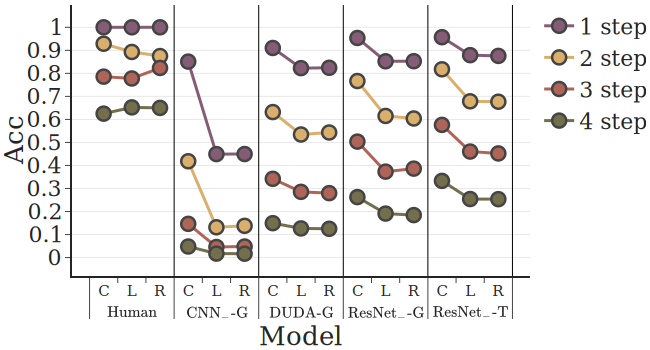

In [13]:
fig = go.Figure()

fig.update_layout(
    font_family="Palatino",
    font_size=22,
    template="simple_white",
    xaxis=dict(title_text="Model"),
    yaxis=dict(title_text="Acc"),
    barmode="overlay",
    width=650,
    height=350,
    margin=dict(l=5, r=5, t=5, b=5),
)
legend_shown = False

for r, c in zip(df.step.unique(), px.colors.qualitative.Antique):

    plot_df = df[df.step == r]
    for m in df.model.unique():
        plot_df_m = plot_df[plot_df.model == m]
        fig.add_trace(
            go.Scatter(
                x=[plot_df_m.model, plot_df_m.view],
                y=plot_df_m["val"],
                name=r,
                mode="lines+markers",
                textposition="bottom center",
                line={"width": 3, "color": c},
                marker={"size": 14},
                showlegend=not legend_shown,
            )
        )
        legend_shown = True
    legend_shown = False

fig.update_yaxes(showgrid=True, nticks=12, linewidth=2, title_standoff=10)
fig.update_xaxes(linewidth=2, title_standoff=10, tickfont=dict(size=15))
fig.update_traces(marker_line_width=2.5)

for x in [2.5, 5.5, 8.5, 11.5, 14.5]:
    fig.add_vline(x=x, line_width=1, line_color="black", opacity=1.)

fig.write_image("view_results.pdf", engine="kaleido")
fig.show(renderer="svg")
